<a href="https://colab.research.google.com/github/ShinAsakawa/ShinAsakawa.github.io/blob/master/2023notebooks/2023_0824pytorch_simple_fine_tune_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# `Dataset` とカスタマイズと，モデルのチェックポイント，微調整 <!-- Custom Dataset, Model Checkpointing, and Fine-tune -->

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os.path as osp
import numpy as np
from PIL import Image

### 1.1 MNIST Dataset のダウンロード

<!--  PyTorch has many built-in datasets such as MNIST and CIFAR.
In this tutorial, we demonstrate how to write your own dataset by implementing a custom MNIST dataset class.
Use [this link](https://github.com/myleott/mnist_png/blob/master/mnist_png.tar.gz?raw=true) to download the mnist png dataset. -->

In [4]:
#%matplotlib inline
import IPython
isColab = 'google.colab' in str(IPython.get_ipython())

if isColab:
    !wget 'https://github.com/myleott/mnist_png/blob/master/mnist_png.tar.gz?raw=true' -O mnist_png.tar.gz
    !tar xvf mnist_png.tar.gz > /dev/null

In [5]:
class MNIST(Dataset):
    """
    カスタマイズする Dataset の例として MNIST を用いる
    """
    def __init__(self,
                 root,
                 transform=None,
                 preload=False):
        """ Intialize the MNIST dataset
        Args:
            - root: root directory of the dataset
            - tranform: a custom tranform function
            - preload: if preload the dataset into memory
        """
        self.images = None
        self.labels = None
        self.filenames = []
        self.root = root
        self.transform = transform

        # read filenames
        for i in range(10):
            filenames = glob.glob(osp.join(root, str(i), '*.png'))
            for fn in filenames:
                self.filenames.append((fn, i)) # (filename, label) pair

        # if preload dataset into memory
        if preload:
            self._preload()

        self.len = len(self.filenames)

    def _preload(self):
        """
        Preload dataset to memory
        """
        self.labels = []
        self.images = []
        for image_fn, label in self.filenames:
            # load images
            image = Image.open(image_fn)
            # avoid too many opened files bug
            self.images.append(image.copy())
            image.close()
            self.labels.append(label)

    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        if self.images is not None:
            # If dataset is preloaded
            image = self.images[index]
            label = self.labels[index]
        else:
            # If on-demand data loading
            image_fn, label = self.filenames[index]
            image = Image.open(image_fn)

        # May use transform function to transform samples
        # e.g., random crop, whitening
        if self.transform is not None:
            image = self.transform(image)
        # return image and label
        return image, label

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [6]:
# transforms.ToTensor() は自動的に，PIL 画像を torch.tensor に変換し，range[0,1] にする
trainset = MNIST(
    root='mnist_png/training',
    preload=True,
    transform=transforms.ToTensor(),

)

# PyTorhch の `dataloader` を使って dataset を扱う
trainset_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)
#trainset_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=1)

# テストデータのロード
testset = MNIST(
    root='mnist_png/testing',
    preload=True, transform=transforms.ToTensor(),
)

testset_loader = DataLoader(testset, batch_size=1000, shuffle=False, num_workers=0)
#testset_loader = DataLoader(testset, batch_size=1000, shuffle=False, num_workers=1)

In [7]:
print(len(trainset))
print(len(testset))

60000
10000


### 1.2 データセットの視覚化 <!-- Visualize the dataset -->

tensor(2) tensor(1) tensor(2) tensor(8) tensor(1) tensor(9) tensor(6) tensor(4) tensor(6) tensor(8) tensor(1) tensor(6) tensor(5) tensor(2) tensor(8) tensor(3)


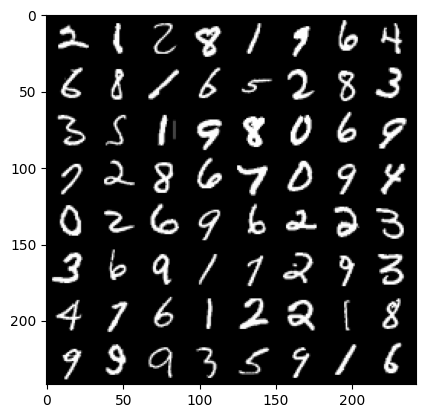

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainset_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(16)))

In [ ]:
# GPU が使えるか否かのチェック
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device('cuda' if use_cuda else "cpu")
print(device)

### 1.3 畳み込みニューラルネットワークの定義 <!-- ### Define a Conv Net -->

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### 1.4. ネットワークの訓練 <!-- ### Train the network -->

In [16]:
def train(epoch, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print(f'訓練エポック: {ep} [{batch_idx * len(data)}/{len(trainset_loader.dataset)}',
                      f'({100. * batch_idx/len(trainset_loader):.0f}%)]',
                      f'\t損失関数: {loss.item():.6f}')
                    #ep, batch_idx * len(data), len(trainset_loader.dataset),
                    #100. * batch_idx / len(trainset_loader), loss.item()))
                # print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #     ep, batch_idx * len(data), len(trainset_loader.dataset),
                #     100. * batch_idx / len(trainset_loader), loss.item()))
            iteration += 1
        test()

In [22]:
def test():
    model.eval()  # set evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testset_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testset_loader.dataset)
    print(f'テストセット: 平均損失値: {test_loss:.4f},',
          f'精度: {correct}/{len(testset_loader.dataset)} ({100. * correct/len(testset_loader.dataset):.0f}%)')
    # print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    #     test_loss, correct, len(testset_loader.dataset),
    #     100. * correct / len(testset_loader.dataset)))

In [23]:
train(5)  # train 5 epochs should get you to about 97% accuracy

訓練エポック: 0 [0/60000 (0%)] 	損失関数: 0.195289
訓練エポック: 0 [6400/60000 (11%)] 	損失関数: 0.362972
訓練エポック: 0 [12800/60000 (21%)] 	損失関数: 0.502602
訓練エポック: 0 [19200/60000 (32%)] 	損失関数: 0.420974
訓練エポック: 0 [25600/60000 (43%)] 	損失関数: 0.444634
訓練エポック: 0 [32000/60000 (53%)] 	損失関数: 0.233365
訓練エポック: 0 [38400/60000 (64%)] 	損失関数: 0.221301
訓練エポック: 0 [44800/60000 (75%)] 	損失関数: 0.355939
訓練エポック: 0 [51200/60000 (85%)] 	損失関数: 0.486433
訓練エポック: 0 [57600/60000 (96%)] 	損失関数: 0.311882
テストセット: 平均損失値: 0.0937, 精度: 9713/10000 (97%)
訓練エポック: 1 [3968/60000 (7%)] 	損失関数: 0.030494
訓練エポック: 1 [10368/60000 (17%)] 	損失関数: 0.136061
訓練エポック: 1 [16768/60000 (28%)] 	損失関数: 0.044361
訓練エポック: 1 [23168/60000 (39%)] 	損失関数: 0.015557
訓練エポック: 1 [29568/60000 (49%)] 	損失関数: 0.182700
訓練エポック: 1 [35968/60000 (60%)] 	損失関数: 0.066888
訓練エポック: 1 [42368/60000 (71%)] 	損失関数: 0.047022
訓練エポック: 1 [48768/60000 (81%)] 	損失関数: 0.127908
訓練エポック: 1 [55168/60000 (92%)] 	損失関数: 0.050828
テストセット: 平均損失値: 0.0655, 精度: 9791/10000 (98%)


## 2. モデルの保存，チェックポイント
<!-- ## 2. Save the model (model checkpointing)  -->

これでモデルが訓練できた！
だが，使用するたびにモデルを再訓練したいわけではない。
さらに，大規模モデルを訓練している場合，定期的にチェックポイントを保存して，何か悪いことが起こったときにいつでも最後のチェックポイントに戻ることができるようにしたい。
単に異なる訓練の繰り返しでモデルを検証したい場合もあるだろう。
<!-- Now we have a model! Obviously we do not want to retrain the model everytime we want to use it.
Plus if you are training a super big model, you probably want to save checkpoint periodically so that you can always fall back to the last checkpoint in case something bad happened or you simply want to test models at different training iterations.-->

PyTorch でのモデルのチェックポイント管理は容易である。
まず，モデルをディスクに保存するヘルパー関数を定義する。
<!-- Model checkpointing is fairly simple in PyTorch. First, we define a helper function that can save a model to the disk -->

In [24]:
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {'state_dict': model.state_dict(),
             'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print(f'model saved to {checkpoint_path}')
    #print('model saved to %s' % checkpoint_path)

def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print(f'model loaded from {checkpoint_path}')
    #print('model loaded from %s' % checkpoint_path)

In [25]:
# create a brand new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
test()

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


テストセット: 平均損失値: 2.3113, 精度: 977/10000 (10%)


### 2.1 都度都度チェックポイントを保存する訓練ループ <!-- ### Define a training loop with model checkpointing -->

In [ ]:
def train_save(epoch, save_interval, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)
            iteration += 1
        test()

    # save the final model
    save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)

In [ ]:
train_save(5, 500, 100)

In [ ]:
# 新モデルの生成
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 最終チェックポイントからデータを読み込む
load_checkpoint('mnist-4690.pth', model, optimizer)

# 最終的な訓練結果が得られる
test()

## 3. モデルの微調整 <!-- ## 3. Fine-tune a model-->

ゼロからモデルを訓練するのではなく，訓練済みモデルを微調整したい場合がある。
例えば，自然画像を含む新しいデータセットでモデルを訓練したい場合などである。
最高の性能を得るには，ImageNet で完全に訓練されたモデルから始めて，モデルを微調整する。
<!-- Sometimes you want to fine-tune a pretrained model instead of training a model from scratch.
For example, if you want to train a model on a new dataset that contains natural images.
To achieve the best performance, you can start with a model that's fully trained on ImageNet and fine-tune the model.-->

PyTorch でモデルを微調整するために，まず，チェックポイントで何を保存したかを確認しよう。
<!--Finetuning a model in PyTorch is super easy! First, let's find out what we saved in a checkpoint -->

In [ ]:
# What's in a state dict?
print(model.state_dict().keys())

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


### 3.1 最終層の全結合層を微調整 <!-- ### Finetune the fc layers -->

チェックポイントから conv 層をロードし，全結合層を再訓練したいとする。
単純に，選択された名前を持つ statedict のサブセットをロードすることができる。
<!-- Now say we want to load the conv layers from the checkpoint and train the fc layers.
We can simply load a subset of the state dict with the selected names -->

In [ ]:
checkpoint = torch.load('mnist-4690.pth')
states_to_load = {}
for name, param in checkpoint['state_dict'].items():
    if name.startswith('conv'):
        states_to_load[name] = param

# Construct a new state dict in which the layers we want
# to import from the checkpoint is update with the parameters
# from the checkpoint
model_state = model.state_dict()
model_state.update(states_to_load)

model = Net().to(device)
model.load_state_dict(model_state)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train(1)  # training 1 epoch will get you to 93%!

### 3.2 他のモデルの訓練済重み係数を輸入<!--Import pretrained weights in a different model-->

訓練済の畳み込み層を別のモデルで使うこともできる。
<!-- We can even use the pretrained conv layers in a different model. -->

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

model = SmallNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
checkpoint = torch.load('mnist-4690.pth')
states_to_load = {}
for name, param in checkpoint['state_dict'].items():
    if name.startswith('conv'):
        states_to_load[name] = param

# Construct a new state dict in which the layers we want
# to import from the checkpoint is update with the parameters
# from the checkpoint
model_state = model.state_dict()
model_state.update(states_to_load)

model.load_state_dict(model_state)

<All keys matched successfully>

In [ ]:
train(1)  # training 1 epoch will get you to 93%!